In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout, LayerNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib

In [2]:
# 🔹 Force TensorFlow to use GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevents memory overflow
        tf.config.set_visible_devices(gpus[0], 'GPU')  # Use only the first GPU if multiple exist
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")


✅ GPU is available and will be used.


In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7014522370658702731
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1734606848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16215537223315931192
physical_device_desc: "device: 0, name: NVIDIA RTX A500 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [4]:
# Load the dataset
file_path = '../csv/one-year-data.csv'
df = pd.read_csv(file_path, delimiter=',')

df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df.set_index('DateTime', inplace=True)

# Drop columns with more than 30% missing values
df.dropna(axis=1, thresh=int(0.7 * len(df)), inplace=True)

# Fill missing values by forward filling
df.ffill(inplace=True)

# Fill any remaining missing values by backward filling
df.bfill(inplace=True)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
df_scaled = df_scaled.astype(np.float32)

In [19]:
print(df_scaled.shape)

(1146239, 71)


In [21]:
# Convert to DataFrame and Save
df_scaled = pd.DataFrame(df_scaled)
df_scaled.to_csv("df_scaled.csv", index=False)
print("✅ df_scaled saved as CSV in 2D format!")

✅ df_scaled saved as CSV in 2D format!


In [5]:
# Define sequence and prediction lengths
sequence_length = 2  # one week (168 hours if data is hourly)
prediction_length = 1  # predicting the next 24 hours

# Function to create sequences
def create_sequences(data, seq_length, pred_length):
    x, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        x.append(data[i:(i + seq_length)])
        y.append(data[(i + seq_length):(i + seq_length + pred_length)])
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

In [6]:
# Create sequences
X, Y = create_sequences(df_scaled.values, sequence_length, prediction_length)

# Split data into training and test sets
train_size = int(0.7 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

In [7]:
# Define the input shape
input_layer = Input(shape=(sequence_length, df_scaled.shape[1]))

# 🔹 Encoder: Add an extra LSTM layer + Layer Normalization
encoder = LSTM(100, return_sequences=True)(input_layer)
encoder = LayerNormalization()(encoder)
encoder = LSTM(50, return_sequences=False)(encoder)
encoder = Dropout(0.2)(encoder)  # Dropout for regularization

# 🔹 Bottleneck Representation
bottleneck = RepeatVector(prediction_length)(encoder)

# 🔹 Decoder: Add an extra LSTM layer + Layer Normalization
decoder = LSTM(50, return_sequences=True)(bottleneck)
decoder = LayerNormalization()(decoder)
decoder = LSTM(100, return_sequences=True)(decoder)
decoder = Dropout(0.2)(decoder)  # Dropout for regularization

# 🔹 Output Layer: Dense layer with activation
output_layer = TimeDistributed(Dense(df_scaled.shape[1], activation="relu"))(decoder)

# 🔹 Build and Compile Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

# 🔹 Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 71)]           0         
                                                                 
 lstm (LSTM)                 (None, 2, 100)            68800     
                                                                 
 layer_normalization (LayerN  (None, 2, 100)           200       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 50)            0         
 )                                                           

In [8]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
# 🔹 Reduce learning rate when loss stops improving
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(X_train, Y_train, epochs=10, batch_size=1024, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/10
627/627 [==============================] - 44s 31ms/step - loss: 0.0192 - val_loss: 0.0094
Epoch 2/10
627/627 [==============================] - 16s 25ms/step - loss: 0.0040 - val_loss: 0.0090
Epoch 3/10
627/627 [==============================] - 16s 26ms/step - loss: 0.0027 - val_loss: 0.0100
Epoch 4/10
627/627 [==============================] - 16s 25ms/step - loss: 0.0021 - val_loss: 0.0103
Epoch 5/10
627/627 [==============================] - 16s 25ms/step - loss: 0.0017 - val_loss: 0.0110
Epoch 6/10
627/627 [==============================] - 16s 25ms/step - loss: 0.0013 - val_loss: 0.0129
Epoch 7/10
627/627 [==============================] - 16s 25ms/step - loss: 0.0010 - val_loss: 0.0114


168/168 [==============================] - 5s 12ms/step
Test RMSE: 2647.904360055325


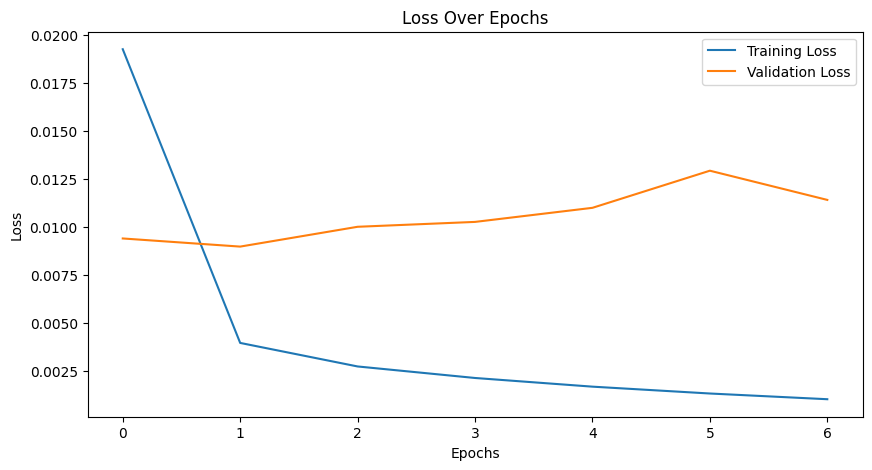

In [9]:
# Evaluate the model
predicted = model.predict(X_test, batch_size=2048)
test_predictions = predicted.copy()  # copy the predicted
predicted = scaler.inverse_transform(predicted.reshape(-1, df_scaled.shape[1])).reshape(predicted.shape)
Y_test_rescaled = scaler.inverse_transform(Y_test.reshape(-1, df_scaled.shape[1])).reshape(Y_test.shape)
rmse = np.sqrt(mean_squared_error(Y_test_rescaled.flatten(), predicted.flatten()))
print(f'Test RMSE: {rmse}')

# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Optionally, save the model
#model.save('lstm_autoencoder_model.h5')


In [10]:
# 🔹 Step 1: Predict the reconstruction for the test data
#test_predictions = model.predict(X_test, batch_size=2048)

# 🔹 Step 2: Reshape the predictions to match the test set
test_predictions = test_predictions.reshape(Y_test.shape[0], Y_test.shape[1], Y_test.shape[2])

# 🔹 Step 3: Compute the reconstruction error (Mean Absolute Error)
test_mse = np.mean(np.abs(Y_test - test_predictions), axis=(1, 2))

In [11]:
model.save("my_model.h5")  # Save model before clearing

import gc
import tensorflow.keras.backend as K

K.clear_session()
gc.collect()


from tensorflow.keras.models import load_model
model = load_model("my_model.h5")  # Restore model


In [12]:
# 🔹 Step 1: Predict the reconstruction for the training data
train_predictions = model.predict(X_train,batch_size=2048)

392/392 [==============================] - 6s 10ms/step


In [13]:
# 🔹 Step 2: Reshape the predictions to match the train set
train_predictions = train_predictions.reshape(Y_train.shape[0], Y_train.shape[1], Y_train.shape[2])

# 🔹 Step 3: Compute the reconstruction error (Mean Absolute Error)
train_mse = np.mean(np.abs(Y_train - train_predictions), axis=(1, 2))

In [14]:
# Compute Reconstruction Error for the Entire Dataset
# 🔹 Step 2: Set a Dynamic Anomaly Detection Threshold
threshold = np.percentile(np.concatenate([train_mse, test_mse]), 95)  # 95th percentile threshold

# 🔹 Step 3: Label Anomalies (1 for Anomaly, 0 for Normal)
train_anomalies = train_mse > threshold
test_anomalies = test_mse > threshold

# 🔹 Step 4: Create a DataFrame with DateTime, Reconstruction Error, and Anomaly Labels
reconstruction_errors = np.concatenate([train_mse, test_mse])  # Merge train & test errors
anomaly_labels = np.concatenate([train_anomalies, test_anomalies])  # Merge train & test anomaly labels

# Ensure alignment with original dataset
df_labeled = df.copy()
df_labeled["Reconstruction_Error"] = np.nan  # Initialize column
df_labeled["Anomaly"] = 0  # Default label = Normal

# Assign computed values to the correct rows
df_labeled.iloc[-len(reconstruction_errors):, df_labeled.columns.get_loc("Reconstruction_Error")] = reconstruction_errors
df_labeled.iloc[-len(anomaly_labels):, df_labeled.columns.get_loc("Anomaly")] = anomaly_labels.astype(int)

# 🔹 Step 5: Save the Fully Labeled Dataset
df_labeled.to_csv("labeled_dataset_with_errors.csv", index=False)

print("✅ Labeled dataset saved as 'labeled_dataset_with_errors.csv'")
print(df_labeled[["Reconstruction_Error", "Anomaly"]].describe())  # Summary stats for verification
print("\n📌 Anomaly Counts:")
print(df_labeled["Anomaly"].value_counts())


✅ Labeled dataset saved as 'labeled_dataset_with_errors.csv'
       Reconstruction_Error       Anomaly
count          1.146237e+06  1.146239e+06
mean           1.961397e-02  5.000004e-02
std            3.379652e-02  2.179451e-01
min            3.266014e-03  0.000000e+00
25%            8.096416e-03  0.000000e+00
50%            1.151800e-02  0.000000e+00
75%            1.707599e-02  0.000000e+00
max            3.766792e-01  1.000000e+00

📌 Anomaly Counts:
Anomaly
0    1088927
1      57312
Name: count, dtype: int64


In [15]:
df.reset_index(inplace=True)
# 🔹 Step 6: Create a DataFrame with DateTime, error values, and anomaly flags
anomaly_df = pd.DataFrame({
    "DateTime": df["DateTime"].iloc[-len(test_anomalies):].values,  # Match timestamps
    "Reconstruction_Error": test_mse,
    "Anomaly": test_anomalies  # Boolean flag (True = Anomaly)
})

In [16]:
# 🔹 Step 7: Filter only detected anomalies
anomaly_df = anomaly_df[anomaly_df["Anomaly"] == True]

# 🔹 Step 8: Save anomalies to a CSV file
anomaly_df.to_csv("detected_anomalies.csv", index=False)
print(f"🔴 Detected {len(anomaly_df)} anomalies, saved to detected_anomalies.csv")

🔴 Detected 26212 anomalies, saved to detected_anomalies.csv


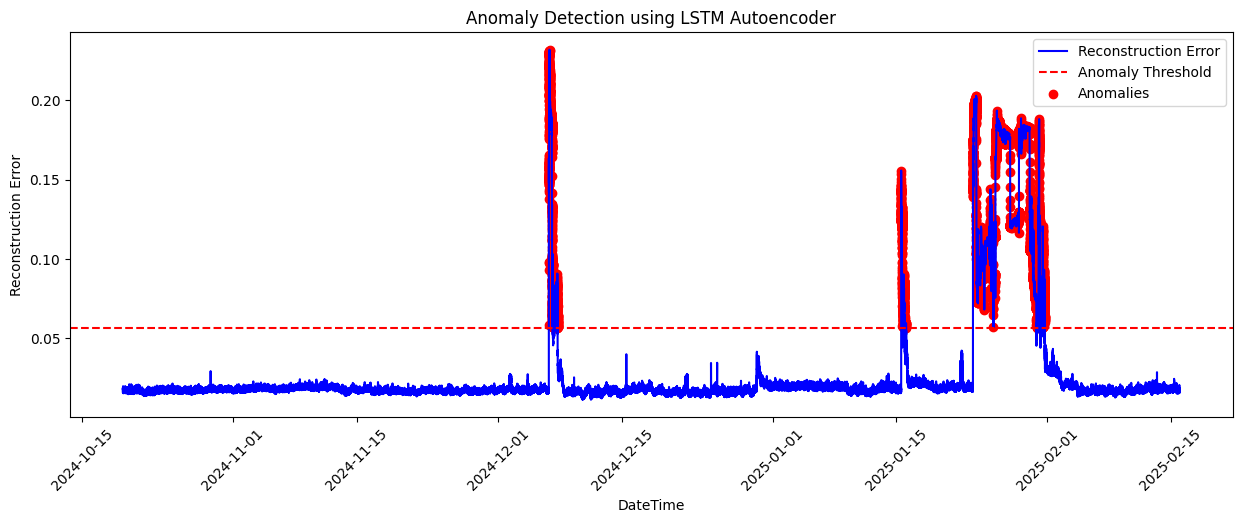

Top Contributing Features to Anomalies:
530R002D02.TI0036.MEAS    483.445009
dtype: float64
✅ Saved feature deviation analysis to anomaly_contributing_features.csv


In [17]:
# Reset index to make "DateTime" a column

# 🔹 Step 9: Plot reconstruction error over time and mark anomalies
plt.figure(figsize=(15, 5))
plt.plot(df["DateTime"].iloc[-len(test_mse):], test_mse, label="Reconstruction Error", color="blue")
plt.axhline(threshold, color="red", linestyle="--", label="Anomaly Threshold")
plt.scatter(anomaly_df["DateTime"], anomaly_df["Reconstruction_Error"], color="red", label="Anomalies", marker="o")
plt.xlabel("DateTime")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.title("Anomaly Detection using LSTM Autoencoder")
plt.xticks(rotation=45)
plt.show()

# 🔹 Step 10: Identify the root cause of anomalies
# Extract data corresponding to anomalies
anomalous_data = df[df["DateTime"].isin(anomaly_df["DateTime"])]

# Compute deviation from normal values for target variables
target_columns = [
    '530R002D02.TI0036.MEAS'

]

feature_deviation = anomalous_data[target_columns] - df[target_columns].mean()

# Identify the most affected features
top_anomalous_features = feature_deviation.abs().mean().sort_values(ascending=False)

# 🔹 Step 11: Display the top contributing features
print("Top Contributing Features to Anomalies:")
print(top_anomalous_features.head(10))  # Show top 10 features

# 🔹 Step 12: Save feature deviation analysis
top_anomalous_features.to_csv("anomaly_contributing_features.csv")
print("✅ Saved feature deviation analysis to anomaly_contributing_features.csv")


In [18]:
# 🔹 Step 11: Identify the Root Cause of Anomalies
# Extract only rows where anomalies were detected
anomalous_data = df[df["DateTime"].isin(anomaly_df["DateTime"])]

# Compute deviation from normal values for **all** features
feature_deviation = anomalous_data.drop(columns=["DateTime"]) - df.drop(columns=["DateTime"]).mean()

# Identify the 5 most deviating features
top_anomalous_features = feature_deviation.abs().mean().sort_values(ascending=False).head(5)

# 🔹 Step 12: Compute Correlation with Target Variable
correlation_with_target = df.drop(columns=["DateTime"]).corrwith(df["530R002D02.TI0036.MEAS"])

# Filter correlation for only the top 5 features
correlation_top_features = correlation_with_target[top_anomalous_features.index]

# 🔹 Step 13: Display Results
print("📌 **Top 5 Contributing Features to Anomalies:**")
print(top_anomalous_features)

print("\n🔗 **Correlation with Target Variable (530R002D02.TI0036.MEAS):**")
print(correlation_top_features)

# 🔹 Step 14: Save the results
result_df = pd.DataFrame({"Deviation": top_anomalous_features, "Correlation": correlation_top_features})
result_df.to_csv("anomaly_contributing_features2.csv")
print("\n✅ Saved feature deviation analysis to 'anomaly_contributing_features.csv'")


E:\apps\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
E:\apps\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


📌 **Top 5 Contributing Features to Anomalies:**
530K001S01.FI0007.MEAS        61188.223184
530UZ0001E01.FZI0008C.MEAS    57482.288700
530UZ0001E01.FZI0008A.MEAS    56694.911681
530UZ0001E01.FZI0008B.MEAS    55529.301940
530R001D01.FI0043.MEAS         1944.109090
dtype: float64

🔗 **Correlation with Target Variable (530R002D02.TI0036.MEAS):**
530K001S01.FI0007.MEAS        0.909561
530UZ0001E01.FZI0008C.MEAS    0.884974
530UZ0001E01.FZI0008A.MEAS    0.886248
530UZ0001E01.FZI0008B.MEAS    0.886598
530R001D01.FI0043.MEAS        0.933878
dtype: float64

✅ Saved feature deviation analysis to 'anomaly_contributing_features.csv'
